In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_missing_70 = train_missing[train_missing.percent<0.7].index
test_missing_70 =  test_missing[test_missing.percent<0.7].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_70) & set(test_missing_70)
features = set(features) - set(categorical_features) 

In [10]:
len(features)

3310

In [11]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]

In [12]:
len(features)

310

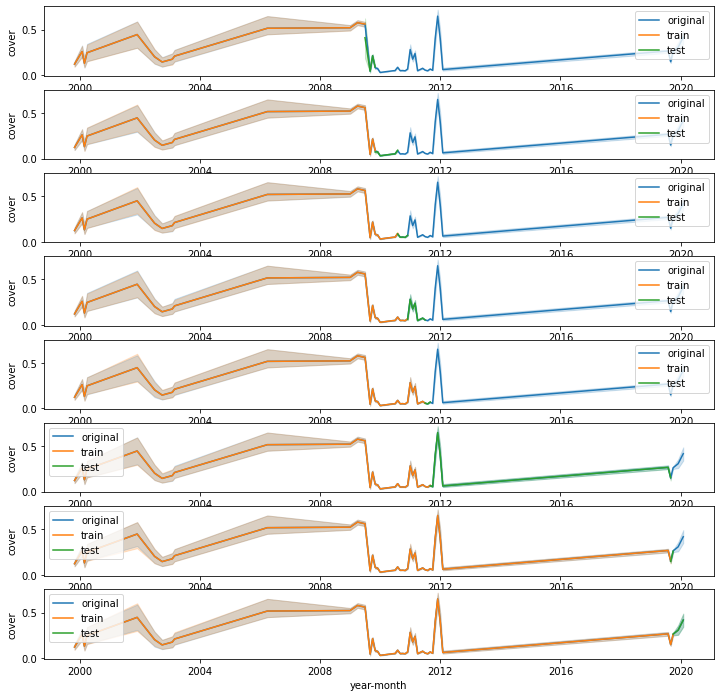

In [13]:
from sklearn.model_selection import TimeSeriesSplit

fig, axes = plt.subplots(8, 1, figsize=(12, 12))

train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
test['year-month'] = test.year.astype(int).astype(str) + '-' + test.month.astype(int).astype(str)
test['year-month'] = pd.to_datetime(test['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)

folds = TimeSeriesSplit(n_splits=8)

for i, (train_index, test_index) in enumerate(folds.split(train)):

    sns.lineplot(data=train, x='year-month', y='cover', ax=axes[i], label='original')
    # 学習用データを描く
    sns.lineplot(data=train.iloc[train_index], x='year-month', y='cover', ax=axes[i], label='train')
    # テスト用データを描く
    sns.lineplot(data=train.iloc[test_index], x='year-month', y='cover', ax=axes[i], label='test')

# グラフを表示する
plt.legend()
plt.show()

## Model

In [14]:
#!pip install iterative-stratification

In [15]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [16]:
class CFG:
  debug=False
  ver=40
  model="lightgbm"
  n_folds=8
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7]
  seed=42
  target_cols="cover"
  boosting_type="gbdt"  #"dart"
  fold_target="cover"

In [17]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df, fold_target):
  Fold = TimeSeriesSplit(n_splits=CFG.n_folds)
  for n, (train_index, val_index) in enumerate(Fold.split(df)):
    df.loc[train_index, f'tr_fold{n}'] = 1
    df.loc[val_index, 'va_fold'] = int(n)
    df[f"tr_fold{n}"] = df[f"tr_fold{n}"].fillna(0)
    df[f'tr_fold{n}'] = df[f'tr_fold{n}'].astype(int)
  df["va_fold"] = df["va_fold"].fillna(999)
  df['va_fold'] = df['va_fold'].astype(int)
  return df

In [18]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [19]:
#features = list(features)
features.remove('id')
features.remove('area')
features.remove("year")
#features.remove("month")
features.append("mesh20")

In [20]:
params1 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "reg_lambda": 0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.1,
        "n_estimators":1000,
        "max_depth":7,
        "colsample_bytree":0.4,
        "max_leaves": int(.7 * 7 ** 2)
    }

In [21]:
def get_pred(df, test, fold_target, target_cols, model, isSelect=False):

  train = get_fold(df, fold_target)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  ctg_list = ["year","month","mesh20"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train[f'tr_fold{fold}'] == 1]
      valid_folds = train[train['va_fold'] == fold]

      print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
      print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              #categorical_feature = ctg_list,
              verbose = 200,
              early_stopping_rounds=50)
      
      valid_folds[f"pred"] = model.predict(valid_X)
      test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"pred"])

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"pred"])
  if isSelect:
    return oof_df, df_importance
  else:
    return oof_df,  test_preds

===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年7.0月
valid period : 2009.0年7.0月 ～ 2009.0年11.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[126]	valid_0's rmse: 0.153712
RMSE 0.15370867243211192
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年11.0月
valid period : 2009.0年11.0月 ～ 2010.0年8.0月


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[93]	valid_0's rmse: 0.156935
RMSE 0.15693473338072395
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年12.0月


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[38]	valid_0's rmse: 0.0790115
RMSE 0.07901154814252208
===============  FOLD : 3  ===============


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年7.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[44]	valid_0's rmse: 0.13528
RMSE 0.13528049800848763
===============  FOLD : 4  ===============


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.13331
RMSE 0.13331034100926267
===============  FOLD : 5  ===============


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2019.0年9.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.230351
RMSE 0.23032930435740015
===============  FOLD : 6  ===============


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.23834
Early stopping, best iteration is:
[203]	valid_0's rmse: 0.238329
RMSE 0.23832897594333685
===============  FOLD : 7  ===============


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.198714
Early stopping, best iteration is:
[202]	valid_0's rmse: 0.198705
RMSE 0.19861953860834236


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


,feature,importance
216,lat,0.018788
142,warm_sst,0.017110
55,month,0.014499
173,lon,0.013893
277,MAX_CI,0.012541
146,fetch,0.012541
58,sst_ymd,0.012075
77,river_dist,0.011702
222,depth_original,0.011469
285,MIN_D678_500,0.010956


RMSE 0.17315894496111942
CPU times: user 3min 43s, sys: 1.67 s, total: 3min 45s
Wall time: 33.5 s


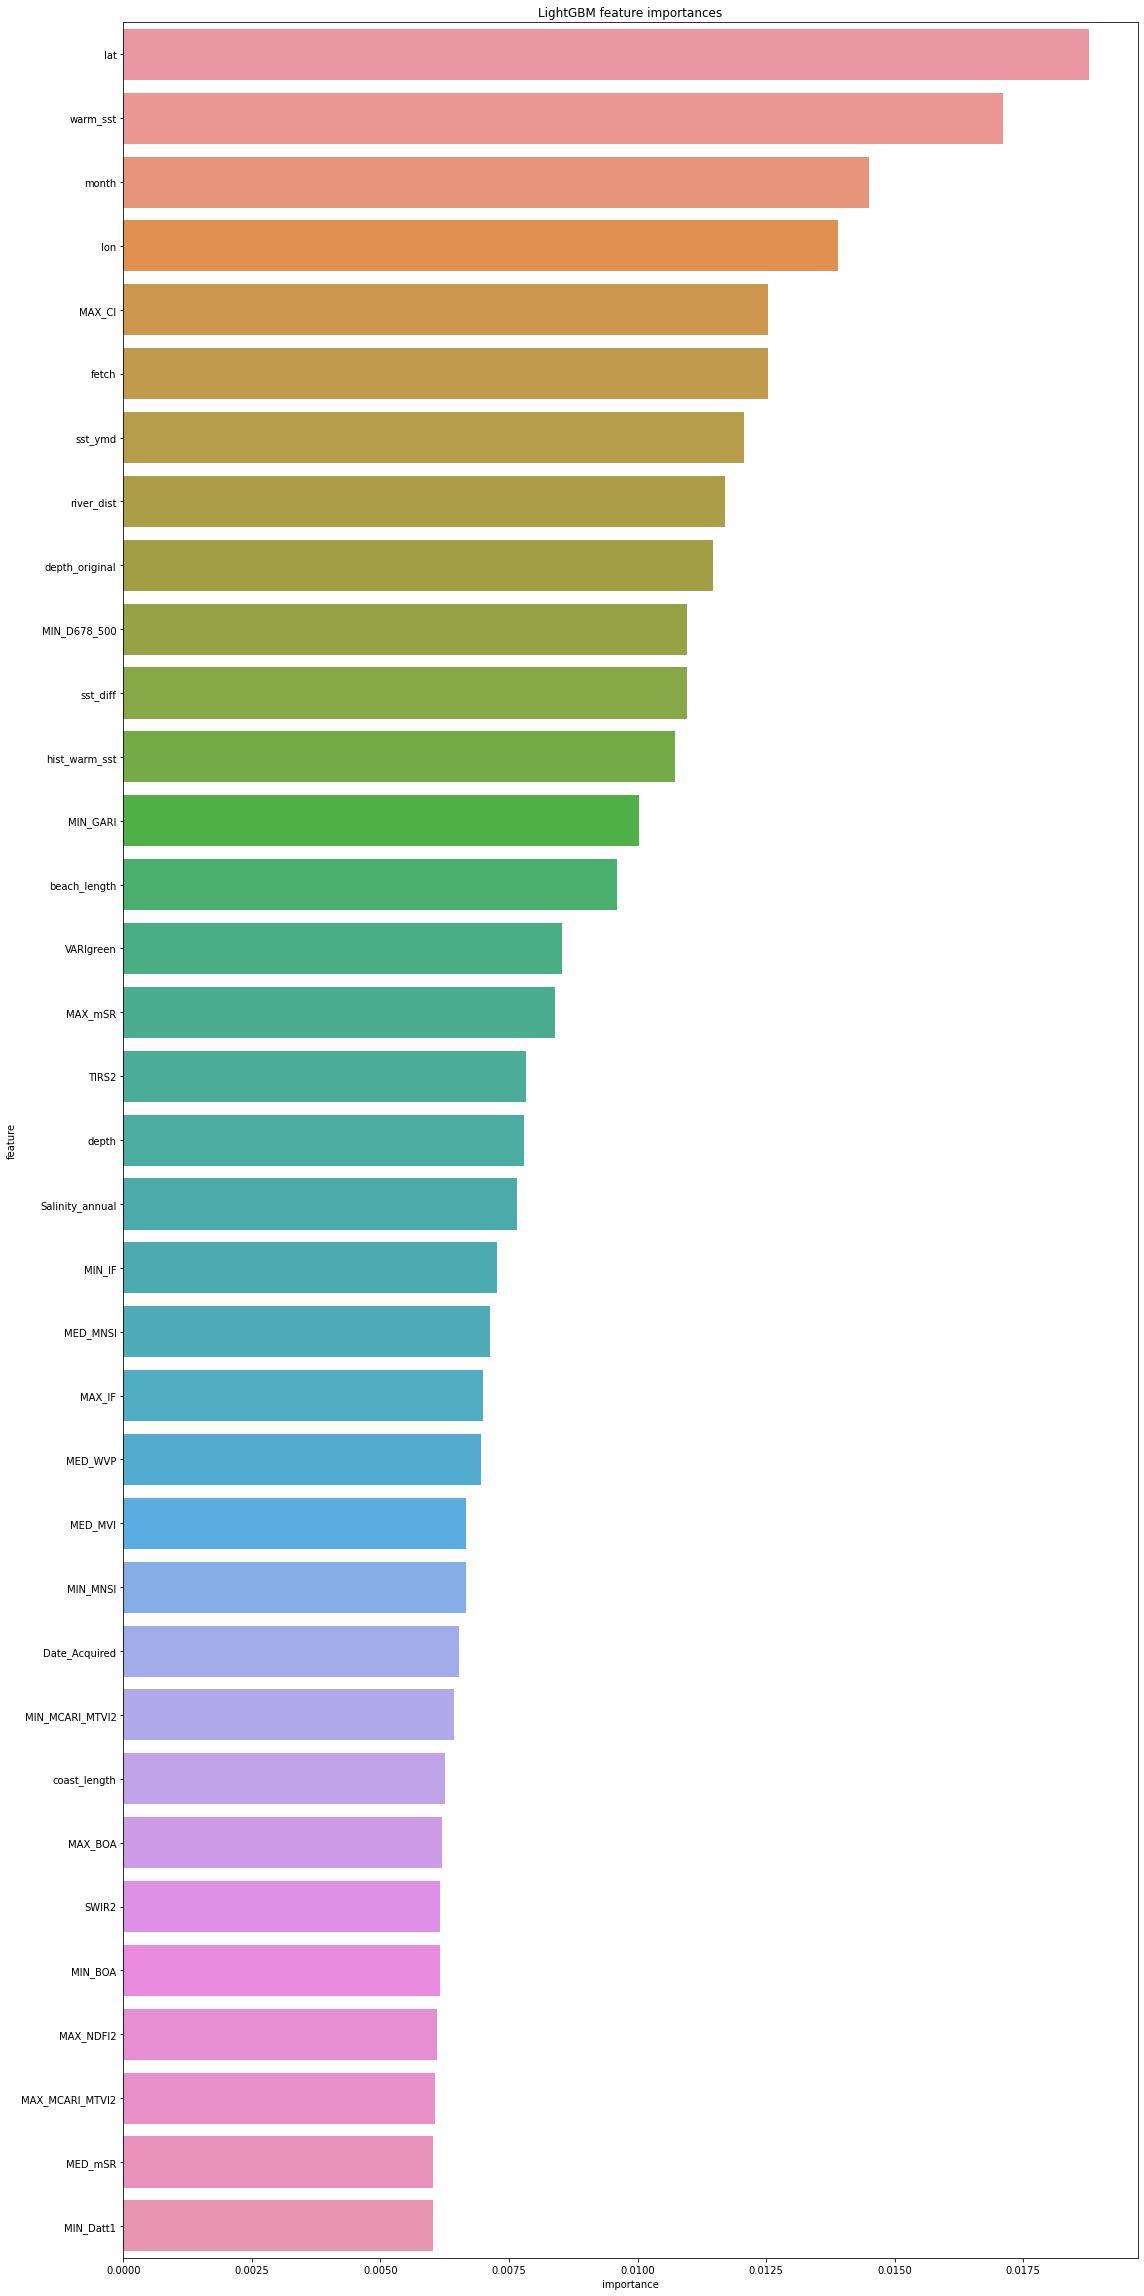

In [22]:
%%time
if CFG.debug:
  print(train.shape)
  train = train.sample(n=200, random_state=CFG.seed).reset_index(drop=True)
  train = train.sort_values("year-month").reset_index(drop=True)
  print(train.shape)

model = lgb.LGBMRegressor(**params1)
select_oof, select_imp = get_pred(train, test, CFG.fold_target, CFG.target_cols, model, isSelect=True)

In [23]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

select_features = select_imp[:35].feature.tolist()

df = pd.concat([train,test]).reset_index(drop=True)
df[select_features] = IterativeImputer(RandomForestRegressor()).fit_transform(df[select_features])
train = df[~df[CFG.target_cols].isnull()]
train = train.sort_values("year-month").reset_index(drop=True)
test = df[df[CFG.target_cols].isnull()]
test = test.sort_values("id").reset_index(drop=True)

features = select_features

===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年7.0月
valid period : 2009.0年7.0月 ～ 2009.0年11.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[59]	valid_0's rmse: 0.18659
RMSE 0.18658975534510586
===============  FOLD : 1  ===============


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)
<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2009.0年11.0月
valid period : 2009.0年11.0月 ～ 2010.0年8.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[45]	valid_0's rmse: 0.140357
RMSE 0.14035705079465444
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年12.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[44]	valid_0's rmse: 0.0871348


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.08713482994503428
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年7.0月
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[36]	valid_0's rmse: 0.14303
RMSE 0.14302968299845406
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
Training until validation scores don't improve for 50 rounds.


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


Early stopping, best iteration is:
[8]	valid_0's rmse: 0.106237
RMSE 0.10623704295584255
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2019.0年9.0月


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[39]	valid_0's rmse: 0.225858


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.22585762300370335
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.230759
[400]	valid_0's rmse: 0.230119
Early stopping, best iteration is:
[379]	valid_0's rmse: 0.229672
RMSE 0.2296724251618498
===============  FOLD : 7  ===============


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.148126
[400]	valid_0's rmse: 0.133325
[600]	valid_0's rmse: 0.127421
[800]	valid_0's rmse: 0.124309
[1000]	valid_0's rmse: 0.122185
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.122185
RMSE 0.12218457033824934


<ipython-input-21-c68c116ecc33>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


,feature,importance
14,VARIgreen,0.041220
8,depth_original,0.040634
29,SWIR2,0.037142
12,MIN_GARI,0.035301
16,TIRS2,0.034925
31,MAX_NDFI2,0.034653
30,MIN_BOA,0.032792
20,MED_MNSI,0.032436
21,MAX_IF,0.031391
1,warm_sst,0.031160


RMSE 0.16301236490751098
CPU times: user 26.7 s, sys: 1.09 s, total: 27.8 s
Wall time: 5.7 s


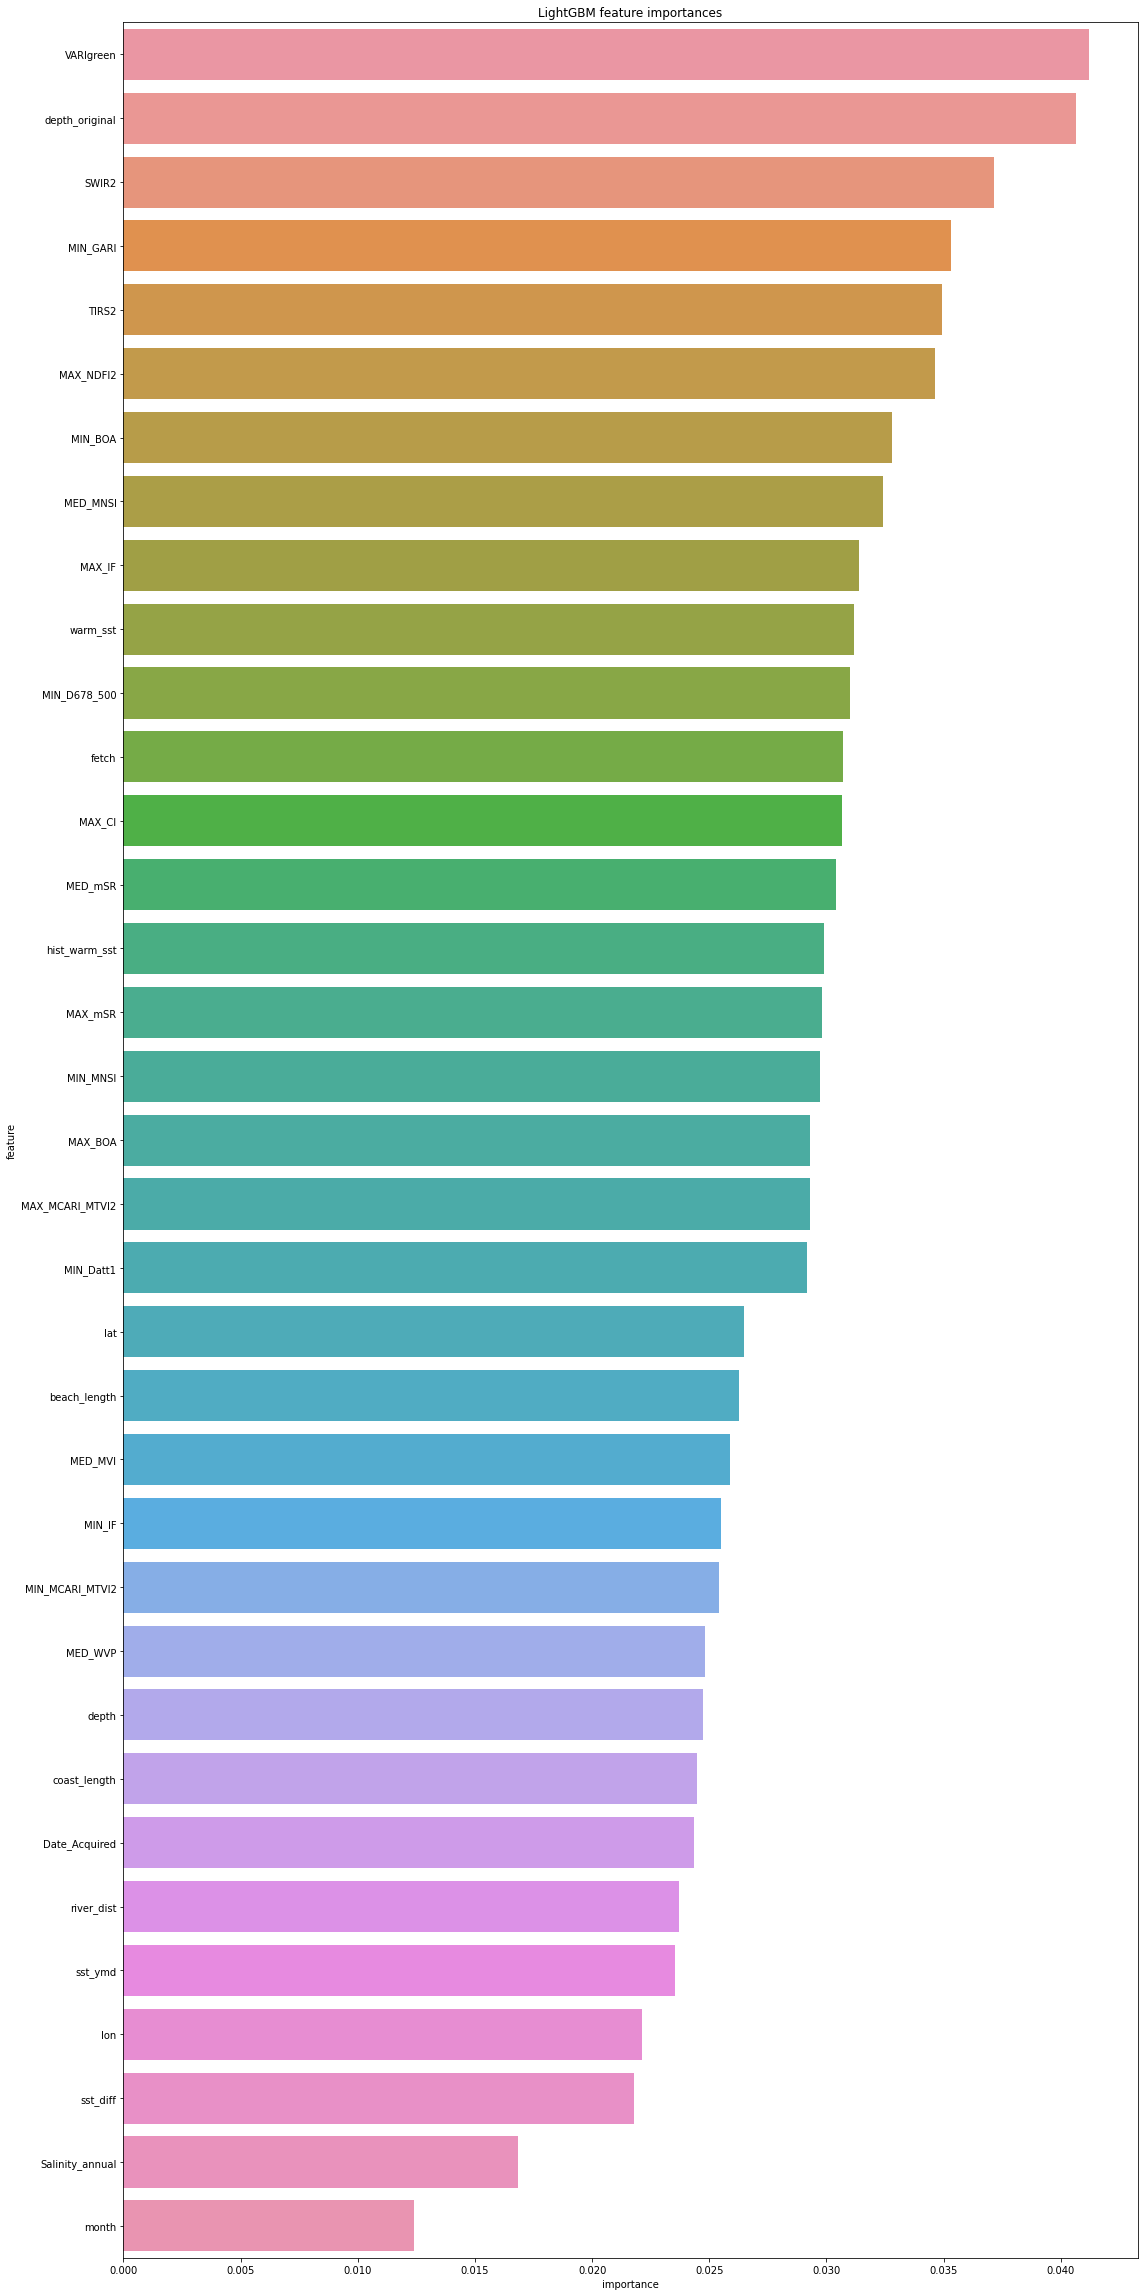

In [24]:
%%time

model = lgb.LGBMRegressor(**params2)
oof_df, test_pred = get_pred(train, test, CFG.fold_target, CFG.target_cols, model)

In [25]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.1629481315545525


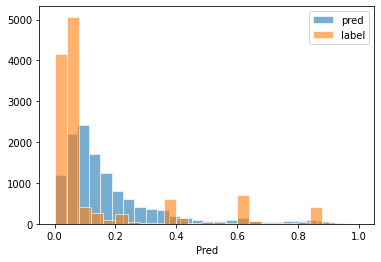

In [26]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [27]:
pred_df = test.copy()
pred_df["pred"] = np.mean(test_pred, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,tr_fold0,va_fold,tr_fold1,tr_fold2,tr_fold3,tr_fold4,tr_fold5,tr_fold6,tr_fold7,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,NaN,0.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045440
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,9.069300,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123942
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,13.800000,73.183418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095884
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,7.629000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080261
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,NaN,-0.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.343441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,NaN,0.400000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082702
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,10.345033,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082286
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,0.100000,76.439651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232017
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,5.069000,73.660492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150504


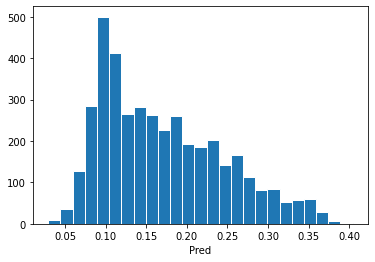

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,tr_fold0,va_fold,tr_fold1,tr_fold2,tr_fold3,tr_fold4,tr_fold5,tr_fold6,tr_fold7,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,NaN,0.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045440
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,9.069300,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123942
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,13.800000,73.183418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095884
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,7.629000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080261
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,NaN,-0.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.343441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,NaN,0.400000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082702
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,10.345033,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082286
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,0.100000,76.439651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232017
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,5.069000,73.660492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150504


In [28]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)

In [29]:
train

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,year-month,tr_fold0,va_fold,tr_fold1,tr_fold2,tr_fold3,tr_fold4,tr_fold5,tr_fold6,tr_fold7
0,4299,24.354412,124.202036,20.0,1999.11.8,1999.0,11.0,0.150,0.3305,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
1,10451,24.351580,124.200529,20.0,1999.11.7,1999.0,11.0,0.200,1.6946,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
2,13086,24.350239,124.203270,20.0,1999.11.8,1999.0,11.0,0.125,1.4239,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
3,7056,24.350341,124.201675,20.0,1999.11.7,1999.0,11.0,0.030,1.0136,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
4,10665,24.353195,124.202396,20.0,1999.11.8,1999.0,11.0,0.005,0.0870,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,4166,24.401757,123.812260,1.5,2020.2.26,2020.0,2.0,0.650,0.4000,0.0,...,2020-02-01,0,7,0,0,0,0,0,0,0
14136,8037,24.400092,123.815836,1.5,2020.2.26,2020.0,2.0,0.560,0.6100,0.0,...,2020-02-01,0,7,0,0,0,0,0,0,0
14137,8637,24.400283,123.813702,1.5,2020.2.26,2020.0,2.0,0.500,0.5500,0.0,...,2020-02-01,0,7,0,0,0,0,0,0,0
14138,11040,24.399529,123.815714,1.5,2020.2.26,2020.0,2.0,0.700,0.5300,0.0,...,2020-02-01,0,7,0,0,0,0,0,0,0


In [30]:
OUTPUT_DF_DIR = os.path.join(OUTPUT_DIR,"DATAFRAME")

if not os.path.exists(OUTPUT_DF_DIR):
    os.makedirs(OUTPUT_DF_DIR)

train.to_csv(os.path.join(OUTPUT_DF_DIR,f"exp{CFG.ver}_train.csv"),index=False)
test.to_csv(os.path.join(OUTPUT_DF_DIR,f"exp{CFG.ver}_test.csv"),index=False)
select_imp.to_csv(os.path.join(OUTPUT_DF_DIR,f"exp{CFG.ver}_imp.csv"),index=False)